### the below block is the whole model

In [0]:
import numpy as np
import matplotlib.pyplot as pl
import math

class Activation(object):

      
    def __relu(self,x):
        
        return np.maximum(0,x)
      
    def __relu_deriv(self,a):
        a[a>0]=1
        a[a<=0]=0
        return a
      
    def __softmax(self, x):
        """
        x is of shape(m,n_in) -- m-number of input data
        :axis = 1 is because of data is stacked up vertically
        """
        y= np.exp(x)/np.sum(np.exp(x),axis=1).reshape(-1,1)
        assert(y.shape == x.shape)
        return y
      
    def __softmax_deriv(self, a):
        
        y = a*(1-a)
        assert(y.shape == a.shape)
        return y

    def __init__(self,activation='relu'):
        if activation == 'softmax':
            self.f = self.__softmax
            self.f_deriv = self.__softmax_deriv
        elif activation == 'relu':
            self.f = self.__relu
            self.f_deriv = self.__relu_deriv

class HiddenLayer(object):    
    def __init__(self, n_in, n_out, W=None, b=None, activation = "relu" ):
        
        """
        :self.act -- the activation name for current layer
        :self.activation -- activation function from class Activation
        :self.activation_deriv -- activation derivative function from class Activation
        """
        self.act = activation

        self.input=None
        self.activation = Activation(activation).f
        self.activation_deriv = Activation(activation).f_deriv

        np.random.seed(7)
        
        """self.W = np.random.uniform(
                low=-np.sqrt(6. / (n_in + n_out)),
                high=np.sqrt(6. / (n_in + n_out)),
                size=(n_in, n_out)
        )"""
        
        self.W = np.random.rand(n_in, n_out)/np.sqrt(n_in / 2)*0.01
        
        self.b = np.zeros((1, n_out))
        
        """
        :grad_W -- gradient of W
        :grad_b -- gradient of b
        :momentum sgd is used here
        :v_dW -- velocity of dW
        :v_db -- velocity of db
        """
        self.grad_W = np.zeros(self.W.shape)
        self.grad_b = np.zeros(self.b.shape)
        
        self.v_dW = np.zeros(self.W.shape)
        self.v_db = np.zeros(self.b.shape)
        
    def forward(self, input, keep_prob):
        '''
        :type input: numpy.array
        :input.shape = (m, n_in), b.shape = (1, n_out), W.shape = (n_in, n_out)
        :lin_output.shape = (m, n_out)
        '''

        lin_output = np.dot(input, self.W) + self.b
        
        assert(self.W.shape[1] == self.b.shape[1])
        assert(input.shape[1] == self.W.shape[0])
        assert(input.shape[0] == lin_output.shape[0])
        
        
        """
        :set keep_prob =1 for last layer and for testing
        """
        if self.act == "softmax":
            keep_prob = 1
  
        self.output = (
            lin_output if self.activation is None
            else self.activation(lin_output)
        )

        output = np.atleast_2d(self.output)
      
        """
        :implements drop out -- randomize d / scale output
        """

        d = np.random.rand(output.shape[0],output.shape[1]) < keep_prob
        output = np.multiply(d, output)
        output /= keep_prob
        
        assert(output.shape == self.output.shape)

        self.input=input
        self.output = output
        return self.output
    
    def backward(self, delta, beta, keep_prob):       
        """
        :self.input.shape = (m, n_in)
        :delta.shape = (m, n_out)
        :self.grad_W.shape = (n_in, n_out)
        :self.grad_b.shape = (1, n_out)
        :delta_.shape = (m, n_in)
        """
        #print("delta={}".format(delta))
        delta = np.atleast_2d(delta)
        self.input = np.atleast_2d(self.input)
        assert(self.input.shape[0] == delta.shape[0])
        m = self.input.shape[0]
        
        self.grad_W = self.input.T.dot(delta)/m
        self.grad_b = np.sum(delta, axis = 0)/m
        
        self.grad_b = np.atleast_2d(self.grad_b)
        
        self.v_dW = beta * self.v_dW + (1-beta) * self.grad_W
        self.v_db = beta * self.v_db + (1-beta) * self.grad_b

        assert(self.v_dW.shape == self.grad_W.shape)
        assert(self.v_db.shape == self.grad_b.shape)
        
        delta_ = delta.dot(self.W.T) * self.activation_deriv(self.input)
        
        delta_ /= keep_prob
        assert(delta_.shape == self.input.shape)
        return delta_
      
class MLP:
    """
    """      
    def __init__(self, layers):
        """
        :param layers: A list containing the number of units in each layer.
        Should be at least two values

        """        
        ### initialize layers

        self.layers=[]
        self.layers_number = layers
        self.params=[]

        self.activation= None 
        
        for i in range(len(layers)-2):
            self.layers.append(HiddenLayer(layers[i],layers[i+1], activation="relu"))

        L = len(layers)
        self.layers.append(HiddenLayer(layers[L-2],layers[L-1], activation="softmax"))
            
    def forward(self, input, keep_prob):
        for layer in self.layers:
            output=layer.forward(input, keep_prob)
            input=output
        
        return output
    
    def criterion_cross_entropy(self, y, y_hat):
        """
        y.shape = y-hat.shape = (m, yn)
        delta.shape = (m, yn)
        :should have bug in here: error, delta
        """
      
        assert(y.shape == y_hat.shape)
        activation_deriv=Activation("softmax").f_deriv
        loss = -np.sum(np.log(y_hat) * y) 
                
        error = y-y_hat
        
        delta = error*activation_deriv(y_hat)
        assert(delta.shape == y.shape)
        return loss, delta
      
    
    def backward(self,delta, beta, keep_prob):        
        for layer in reversed(self.layers):
            delta=layer.backward(delta, beta, keep_prob)
            
    def update(self,lr):
        """
        v_db.shape = (m, n_out)
        b.shape = (1, n_out)
        """
        for layer in self.layers:
            layer.W += lr * layer.v_dW                   
            layer.b += lr * layer.v_db
   
    def create_mini_batch(self, mini_batch_size, labels, X, y, yn, num_features, m):
        """
        
        """
        #initializations
        np.random.seed(1)

        mini_batches = []            
        permutation = list(np.random.permutation(m))
        shuffled_X = X[permutation, :]
        shuffled_y = y[permutation, :]
        
        labels = labels[permutation]
        mini_batches_labels = labels

        num_com_batches = math.floor(m/mini_batch_size)
        
        for k in range(0, num_com_batches):
            mini_batch_X = shuffled_X[k*mini_batch_size:(k+1)* mini_batch_size, : ]
            mini_batch_y = shuffled_y[k*mini_batch_size:(k+1)* mini_batch_size, : ]
            mini_batch = (mini_batch_X, mini_batch_y)
            mini_batches.append(mini_batch)
            assert(mini_batch_X.shape == (mini_batch_size, num_features))
            assert(mini_batch_y.shape == (mini_batch_size, yn))
            
        if m % mini_batch_size !=0: 
            mini_batch_X = shuffled_X[(k+1)*mini_batch_size:, : ]
            mini_batch_y = shuffled_y[(k+1)*mini_batch_size:, : ]
            mini_batch = (mini_batch_X, mini_batch_y)
            mini_batches.append(mini_batch)
            
        return mini_batches, mini_batches_labels
      
    def fit_pre_processing(self, X, labels, epochs):
        """
        :labels -- original labels for data. e.g. np.array(3,2,9,...)
        :y -- vectorized labels -- there are ten classes of labels in total
        :yn -- number of classes. i.e. 10
        :num_features -- number of features from input X
        :m -- number of data points: 1 to 60000
        """
      
        labels = labels.flatten()
        assert(X.shape[0] == labels.shape[0])

        y = (np.arange(self.layers_number[-1]) == labels[:, None]).astype(float)
        yn = y.shape[1]
        assert(y.shape[0] == X.shape[0])
                
        num_features = X.shape[1]       
        m = X.shape[0]
        
        to_return_cost = np.zeros(epochs)
        to_return_accuracy = np.zeros(epochs)
        
        return y, yn, num_features, m, to_return_cost, to_return_accuracy
      
    def fit(self, X, labels, learning_rate=0.1, epochs=100, keep_prob = 1, beta=0, mini_batch_size = 1, X_test = None, labels_test = None, ):
        
        """
        :X.shape = (m, num_features)
        :labels.shape = (m, 1) / (m,)
        :y.shape = (m, yn)
        :y_hat.shape = y.shape
        """
        y, yn, num_features, m, to_return_cost, to_return_accuracy = self.fit_pre_processing(X, labels, epochs)
        
        if X_test and labels_test:
            y_test, yn_test, num_features_test, m_test, to_return_cost_test, to_return_accuracy_test = self.fit_pre_processing(X_test, labels_test, epochs)

            assert(num_features == num_features_test)
            assert(yn == yn_test)

            num_features_test = num_features
            yn_test = yn

        mini_batches, mini_batches_labels = self.create_mini_batch(mini_batch_size, labels, X, y, yn, num_features, m)

        for k in range(epochs):
            y_hat_labels = []

            for mini_batch in mini_batches:
                
                mini_batch_X, mini_batch_y = mini_batch
                
                mini_batch_y_hat = self.forward(mini_batch_X, keep_prob)
                
                loss, delta=self.criterion_cross_entropy(mini_batch_y, mini_batch_y_hat)
                
                self.backward(delta, beta, keep_prob)
                
                self.update(learning_rate)
                
                y_hat_label = mini_batch_y_hat.argmax(axis = 1)
                
                y_hat_labels = np.append(y_hat_labels, y_hat_label)
    
            to_return_cost[k] = np.mean(loss)
            
            assert(len(y_hat_labels) == len(mini_batches_labels))
            to_return_accuracy[k] = str(np.sum((y_hat_labels == mini_batches_labels)/m)) 
            
            if X_test and labels_test:
              
                y_hat_test = self.forward(X_test, keep_prob = 1)
                
                loss_test, delta_test=self.criterion_cross_entropy(y_test, y_hat_test)
                
                y_hat_label_test = y_hat_test.argmax(axis = 1)
                
                assert(len(y_hat_label_test) == len(labels_test))
                
                to_return_cost_test[k] = np.mean(loss_test)
                
                to_return_accuracy_test[k] = str(np.sum((y_hat_label_test == labels_test)/m_test))
            
            #if k % 10000 ==0:
            if k % 100 ==0:
                print("Cost after iteration %i: %f" %(k, to_return_cost[k]))
                print("Accuracy after iteration %i: %f" %(k, to_return_accuracy[k]))

        print("accuracy: ", to_return_accuracy[k])
        print("cost: ", to_return_cost[k])
        if X_test and labels_test: 
            print("accuracy_test: ", to_return_accuracy_test[k])
            print("cost_test: ", to_return_cost_test[k])
        
        if X_test and labels_test:
            return to_return_cost, to_return_accuracy, to_return_cost_test, to_return_accuracy_test, y_hat_label_test        
        else:
            return to_return_cost, to_return_accuracy


### This MLP_train altomatically trains the training data. just need to input number of inputs: m and other parameters.

In [0]:

class MLP_train():
    """
    hidden layers - a python list
    """
    def __init__(self, m, num_features = 128, yn = 10):
        self.m = m
        self.num_features = num_features
        self.yn = yn
        
        """
        :uses X as input 
        """

        self.X_train = X[0:m,:]
        self.labels_train = labels[0:m]
   
    def cal(self, mini_batch_size = 1, beta = .8, keep_prob = 1, learning_rate = .005, epochs = 100, hidden_layers = None):
        
        m = self.m
        num_features = self.num_features
        yn = self.yn
        
        if mini_batch_size > m: 
          raise ValueError('mini_batch_size too big')
         
        if hidden_layers == None:
            layers_number = [num_features, yn]
        else:
            layers_number = [num_features] + hidden_layers + [yn]
          
        case = MLP(layers_number)
        cost, accuracy = case.fit(self.X_train, self.labels_train, learning_rate, epochs, keep_prob, beta, mini_batch_size, X_test = None, labels_test= None)

        %matplotlib inline
        
        pl.plot(cost)
        pl.plot(accuracy)
        

    

### input data from local

In [8]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving train_label.h5 to train_label.h5
User uploaded file "train_label.h5" with length 482144 bytes


### load in data

In [0]:

import numpy as np
with h5py.File('train_128.h5','r') as H:
    X = np.copy(H['data'])

with h5py.File('train_label.h5','r') as H:
    labels = np.copy(H['label'])

### normalise data: using z_score or normalisation method

In [0]:
def z_score(x, axis):
    x = np.array(x).astype(float)
    xr = np.rollaxis(x, axis=axis)
    xr -= np.mean(x, axis=axis)
    xr /= np.std(x, axis=axis)
    # print(x)
    return x
  


In [0]:
"""
"""
def norm(x, axis):
    x = np.array(x).astype(float)
    xr = np.rollaxis(x, axis=axis)
    x_mean = np.mean(x, axis = axis)
    x_max = np.max(x, axis = axis)
    x_min = np.min(x, axis = axis)
    xr -= x_mean
    xr /=(x_max-x_min)

    return x

In [35]:
"""
for testing 
"""
x = np.array([[1,2,3],
             [2,1,6]])
#z_score(x,1)
norm(x,1)

array([[-0.5,  0. ,  0.5],
       [-0.2, -0.4,  0.6]])

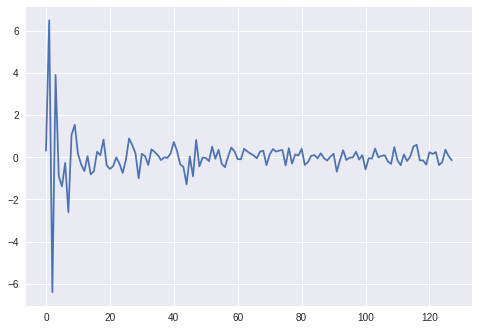

In [36]:
X_z_score = z_score(X, 1)
pl.plot(X_z_score[800])

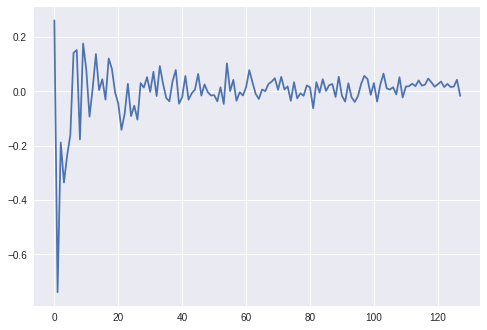

In [37]:
"""
for testing normalization methods on X
"""
X_norm = norm(X, 1)
pl.plot(X_norm[80])

### train the training data

In [99]:
"""
- the X_train is the data to be trained - can be itself, i.e. X_train, or X_norm, etc.
- in test_1 = MLP_train(m= ). the m needs to be specified
- in test_1.cal, parameters need to be specified
- when encountered with runtime warning, it means either the normalization of X is not enough or learning rate is not appropriate
"""
X= X_norm
#test_1 = MLP_train(m=10000)
test_1 = MLP_train(m=100)
#test_1.cal(mini_batch_size = 128, beta = .6, keep_prob = .5, learning_rate = 0.01, epochs = 500000, hidden_layers = [5,10])
test_1.cal(mini_batch_size = 1, beta = .8, keep_prob = .9, learning_rate = 0.1, epochs = 500000, hidden_layers = [5,10])

[[ 1.17652830e-04  1.32347103e-04  1.49684346e-04  9.14193440e-06
  -6.93570930e-05 -7.24701645e-06  3.10046137e-05 -1.11335033e-04
  -7.14117380e-05  1.47431662e-04]]
[[5.25970877e-12 3.08977031e-12 3.29322576e-12 2.88622312e-12
  3.61739522e-12]]
[[1.31658431e-14 6.06760436e-15 6.90352456e-15 6.84166208e-15
  1.18970309e-14 1.07103641e-14 7.56132932e-15 8.41708692e-15
  8.31281045e-15 1.03650692e-14 8.91226422e-15 9.24018232e-15
  7.38899816e-15 1.42375732e-14 7.55791225e-15 4.96855464e-15
  1.09376513e-14 1.24839399e-14 9.11576257e-15 1.05993090e-14
  9.97841610e-15 9.14278446e-15 9.31330072e-15 4.91180090e-15
  1.06835882e-14 1.12178656e-14 1.09309155e-14 1.11216665e-14
  6.05680357e-15 2.69534934e-15 7.82639842e-15 1.20285551e-14
  1.35170517e-14 8.06775659e-15 8.18428483e-15 6.80543364e-15
  6.34131718e-15 1.04105315e-14 5.84628753e-15 1.13074163e-14
  1.04970571e-14 9.51190399e-15 8.62086828e-15 1.04204428e-14
  8.65174622e-15 9.23752819e-15 9.37140390e-15 7.40937192e-15
  9.737


[[ 1.76665536e-05  1.71014067e-04 -1.79754117e-04  1.44238468e-04
   7.47545875e-05 -1.78132887e-04 -1.50843085e-04  2.94322727e-05
  -2.93062741e-05 -4.48805483e-05]]
[[7.06140092e-13 4.22656250e-13 8.71436548e-13 1.63061506e-13
  1.97840781e-13]]
[[5.30619205e-16 8.72055429e-17 4.61063925e-16 5.47218534e-16
  2.78742147e-16 9.08242470e-16 4.50707817e-16 3.80036720e-16
  7.95669331e-16 1.09706995e-15 7.67808060e-16 8.58600280e-16
  6.43031702e-17 1.14381884e-15 3.73669157e-16 4.15792066e-16
  5.42373221e-16 9.41894131e-16 4.92068863e-17 8.68098743e-16
  9.83790802e-16 9.20473154e-16 6.55322865e-16 2.78896821e-16
  2.05179401e-16 9.64572972e-16 1.10040948e-15 2.03668404e-16
  4.30015267e-17 4.37674949e-16 8.43230934e-16 1.13850933e-15
  1.12150608e-15 1.05616558e-15 1.10226248e-15 5.06037808e-16
  8.92118715e-16 2.49673659e-16 2.81608467e-16 4.62964148e-16
  9.01481349e-16 8.61812968e-16 5.13936401e-16 7.70376950e-16
  7.21415261e-16 1.26735079e-16 9.50617115e-16 6.21193134e-16
  1.08


[[2.73626292e-12 2.10470409e-12 2.78735492e-12 2.18818201e-12
  3.41494879e-12 2.26063055e-12 1.77219148e-12 2.89374833e-12
  2.42111000e-12 3.52222199e-12 2.38453822e-12 1.76450705e-12
  3.04618475e-12 3.18002753e-12 2.67787668e-12 1.65766117e-12
  2.22302498e-12 3.05446906e-12 2.72918017e-12 3.30150473e-12
  2.19217460e-12 3.47823130e-12 2.38456671e-12 2.00696294e-12
  2.25709309e-12 1.94310613e-12 2.89480922e-12 3.27518605e-12
  2.04049936e-12 6.73422043e-13 1.63492463e-12 2.59079818e-12
  3.01355996e-12 3.38235021e-12 2.42070037e-12 1.65059890e-12
  2.27493121e-12 2.22450515e-12 1.20852313e-12 3.03218743e-12
  2.79510755e-12 2.24709551e-12 3.17010977e-12 3.44925586e-12
  2.52350362e-12 2.33790673e-12 3.14260709e-12 2.13180012e-12
  2.94145366e-12 2.77240332e-12 2.11105752e-12 3.25663444e-12
  2.13803254e-12 2.75787000e-12 1.33832473e-12 2.57118407e-12
  3.09444377e-12 2.15978479e-12 1.61721367e-12 1.80419943e-12
  2.05490192e-12 3.00040081e-12 3.47567138e-12 2.06664133e-12
  1.831

[[-2.58613781e-12 -1.62638478e-12 -2.29344527e-12 -3.50306132e-12
  -2.77171530e-12 -2.90526018e-12 -2.02703793e-12 -3.10266612e-12
  -2.56275333e-12 -3.10142827e-12 -2.77233247e-12 -2.09148457e-12
  -2.33459848e-12 -4.00852734e-12 -2.40242316e-12 -1.81033006e-12
  -2.48776153e-12 -3.71964668e-12 -3.17319384e-12 -2.73464510e-12
  -2.43481119e-12 -2.94236905e-12 -2.47886080e-12 -2.68289838e-12
  -2.22246146e-12 -3.32284139e-12 -2.82076961e-12 -2.90021249e-12
  -1.31560041e-12 -7.86729886e-13 -2.31361863e-12 -4.02445086e-12
  -2.99966032e-12 -3.16052213e-12 -2.08053784e-12 -1.38829097e-12
  -2.46295884e-12 -2.49068104e-12 -1.51944672e-12 -3.03908334e-12
  -3.70736348e-12 -3.14029209e-12 -3.65419089e-12 -4.17651330e-12
  -1.76877749e-12 -2.15871782e-12 -2.58267756e-12 -2.80577077e-12
  -4.21982802e-12 -3.19687920e-12 -2.64022806e-12 -3.86906735e-12
  -2.52780723e-12 -3.08175868e-12 -2.33340179e-12 -2.26072663e-12
  -1.95990317e-12 -2.11341836e-12 -4.85625997e-13 -1.06609597e-12
  -3.07861

[[1.79728506e-12 1.00114585e-12 1.54172377e-12 1.36944084e-12
  1.89170051e-12 1.66405342e-12 1.25046240e-12 1.78048377e-12
  1.26904451e-12 1.48021006e-12 1.43241027e-12 9.45569505e-13
  1.34971017e-12 2.52135244e-12 8.65539996e-13 7.34564356e-13
  1.36990389e-12 1.81921401e-12 1.97768542e-12 1.77697629e-12
  1.33184080e-12 1.81746710e-12 9.30954042e-13 9.43095270e-13
  1.39821928e-12 1.86652772e-12 1.98091339e-12 1.80323413e-12
  5.37641667e-13 3.21194332e-13 1.45934055e-12 2.12697524e-12
  2.04859437e-12 1.65941503e-12 9.03899288e-13 9.06215324e-13
  1.17497893e-12 1.27400641e-12 9.49565210e-13 2.00227416e-12
  1.35244793e-12 1.86276719e-12 2.15290922e-12 2.22679714e-12
  8.85760749e-13 1.17652055e-12 1.12377796e-12 1.26111788e-12
  1.89473823e-12 1.42871733e-12 8.81129394e-13 1.92202995e-12
  8.50620741e-13 2.00839772e-12 9.01498773e-13 1.18332425e-12
  1.71987659e-12 1.49026900e-12 3.14879219e-13 9.09205406e-13
  1.43259096e-12 1.93738540e-12 2.34445238e-12 1.06870839e-12
  1.6653


[[-3.75833425e-10  4.25841956e-10 -1.32028959e-10  1.60878786e-10
   5.33273851e-10]]
[[ 5.02709237e-13  6.20641072e-14  6.56938111e-14 -2.23430945e-13
   3.28794478e-13  2.51936912e-13  2.21718970e-13  8.75991724e-14
  -6.54094183e-14 -2.57112073e-13  3.22604643e-14  4.09004279e-14
  -3.55697450e-14  4.64269459e-13 -3.14859036e-13 -1.63146927e-13
   2.49973889e-13  5.53102507e-14  3.25799259e-13  1.24252360e-13
   1.21555645e-13 -3.22437291e-14 -1.72413152e-13 -3.10793780e-13
   3.66730784e-13  3.69201331e-13  3.07668392e-13  2.42269427e-13
  -1.33133344e-13 -7.06033620e-14  2.65905200e-13  2.25480384e-13
   4.18312278e-13 -2.46270468e-13 -2.33558434e-13  1.40008481e-13
  -1.91112728e-13  2.06188778e-13  2.20866337e-13  3.58855387e-13
  -2.81182819e-13  2.63664395e-13  1.11692077e-13  2.15262135e-14
  -1.03629420e-13  1.55614991e-13 -2.96950375e-13 -8.55769912e-14
  -1.69880364e-13 -1.70723501e-13 -4.62439069e-13 -9.13755045e-14
  -2.91784263e-13  4.68361964e-13  3.48876187e-14 -3.53

[[2.59709096e-12 1.10680959e-12 1.29710471e-12 6.16110201e-13
  2.28220222e-12 1.91439259e-12 1.35597656e-12 1.29960265e-12
  1.44671444e-12 1.91558375e-12 1.50775438e-12 1.71827053e-12
  1.26722472e-12 2.56035792e-12 1.18179301e-12 7.40275711e-13
  1.98692971e-12 2.06992995e-12 1.36122174e-12 2.12520234e-12
  1.90305420e-12 1.75778459e-12 1.57797887e-12 3.81482851e-13
  1.98105638e-12 1.85232791e-12 2.21432457e-12 1.99337950e-12
  1.11423098e-12 4.98717931e-13 1.41442630e-12 1.89463157e-12
  2.73087595e-12 1.40422057e-12 1.63225275e-12 1.40320255e-12
  1.04673353e-12 1.77177508e-12 1.02806657e-12 2.05325794e-12
  1.48194013e-12 1.57956529e-12 1.24930036e-12 1.51677738e-12
  1.79126695e-12 1.63128814e-12 1.76589634e-12 1.05126660e-12
  1.27743747e-12 1.47054323e-12 3.65395536e-13 1.67674864e-12
  5.29013768e-13 2.14468792e-12 9.69994495e-13 2.02096247e-12
  2.56341191e-12 1.22938152e-12 1.36052367e-12 1.61559140e-12
  5.54025788e-13 2.18699356e-12 2.62174677e-12 1.87962352e-12
  1.4091

[[ 1.70190828e-05  1.87682890e-04 -1.77954888e-04  1.51445839e-04
   8.34027258e-05 -1.73514813e-04 -1.43180742e-04  2.90038195e-05
  -2.21596034e-05 -5.25419432e-05]]
[[ 7.23703656e-10 -2.38829983e-10  1.60812088e-09 -7.79749276e-10
  -7.63290447e-10]]
[[-1.02311858e-12 -2.84688636e-13  8.90078887e-13  8.18433163e-13
  -7.54940140e-13  4.15874278e-13 -3.00717431e-14  3.75785048e-13
   9.18607025e-13  1.62943414e-12  6.93845851e-13  2.49384295e-13
  -1.10189509e-13  6.07486421e-13  2.04011458e-13  5.40380803e-13
  -6.53870863e-13  4.34002170e-13 -6.57643692e-13  9.58168306e-13
   6.67498046e-13  1.70485102e-12  1.19950539e-13  5.64513825e-13
  -1.34246067e-12  2.90347492e-13  1.22782885e-12 -7.58186280e-13
  -5.84080821e-13  6.22564484e-13  8.00174868e-13  9.07153882e-13
   4.90209023e-13  2.30365034e-12  1.52674838e-12  1.37060856e-13
   1.70128984e-12 -1.18126428e-12 -2.76902561e-13 -2.82815403e-13
   7.34276342e-13  7.89707822e-13  9.25065856e-13  1.12019791e-12
   5.09800255e-13 -1


[[ 1.25663656e-04  1.63739564e-04  1.72005950e-04  2.16507908e-05
  -5.69662373e-05  1.02539380e-05  5.43758358e-05 -1.08029459e-04
  -5.59620215e-05  1.48095387e-04]]
[[1.80323209e-09 1.68903296e-09 1.67191696e-09 1.42367004e-09
  1.41952811e-09]]
[[6.39744273e-12 4.20783894e-12 5.16962160e-12 5.71887757e-12
  7.14472067e-12 5.54899184e-12 4.19441713e-12 6.30738874e-12
  5.12615850e-12 6.69321494e-12 5.38328023e-12 4.27664153e-12
  5.89740813e-12 7.65584682e-12 5.51009725e-12 3.56936298e-12
  5.53076058e-12 7.28111937e-12 6.57901590e-12 6.31592127e-12
  4.92692254e-12 6.35886174e-12 5.38252605e-12 4.75901555e-12
  5.53975531e-12 5.65336558e-12 5.85247344e-12 7.08274736e-12
  3.99514440e-12 1.39162747e-12 4.01656459e-12 6.83803044e-12
  6.55453283e-12 6.20854805e-12 4.47826686e-12 3.38179011e-12
  4.49156647e-12 5.70373537e-12 3.11145735e-12 6.76914268e-12
  6.81853612e-12 5.53873919e-12 6.91725259e-12 7.75039059e-12
  4.68012758e-12 5.40925603e-12 5.88738594e-12 5.07828518e-12
  7.02

[[7.34802274e-12 5.04844664e-12 6.17326148e-12 7.04009675e-12
  8.38969415e-12 6.47873910e-12 4.87808226e-12 7.51997289e-12
  6.23641917e-12 8.29872547e-12 6.46016739e-12 5.14833534e-12
  7.16820559e-12 8.82852387e-12 6.94006504e-12 4.44058878e-12
  6.49769782e-12 8.74010496e-12 7.65537227e-12 7.52779239e-12
  5.85138806e-12 7.68545268e-12 6.67011963e-12 5.97706364e-12
  6.42548709e-12 6.48569415e-12 6.79301275e-12 8.37811401e-12
  4.98467559e-12 1.73423469e-12 4.59704064e-12 8.02055235e-12
  7.57468547e-12 7.66432527e-12 5.61232852e-12 3.98454135e-12
  5.55133721e-12 6.75062669e-12 3.57313629e-12 7.87882460e-12
  8.45619700e-12 6.42714701e-12 8.20695064e-12 9.28982614e-12
  5.77719312e-12 6.44168242e-12 7.37530125e-12 6.17892261e-12
  8.56564408e-12 7.45734488e-12 5.64115374e-12 8.64425481e-12
  6.32741886e-12 7.76899423e-12 5.10000715e-12 6.14343596e-12
  6.63711698e-12 4.92597241e-12 3.48273185e-12 4.19392156e-12
  6.63956891e-12 8.49445615e-12 9.52148585e-12 5.60411918e-12
  5.6339

[[4.74392670e-10 3.16850944e-11 5.54001132e-10 4.57567561e-10
  8.25762328e-10]]
[[1.66602700e-12 1.12075084e-12 8.55261420e-13 1.22904312e-12
  1.82875573e-12 1.07240856e-12 8.79606659e-13 1.26643003e-12
  1.07579322e-12 1.45680014e-12 1.10520809e-12 1.13665704e-12
  1.53551508e-12 1.27825540e-12 1.70527302e-12 8.76852337e-13
  1.53313852e-12 1.70241251e-12 1.44244481e-12 1.19757514e-12
  1.02112371e-12 1.00243955e-12 1.64399474e-12 1.19701996e-12
  1.65292282e-12 9.79890829e-13 7.81924286e-13 1.86019839e-12
  1.47491141e-12 2.41738905e-13 4.64110947e-13 1.15218190e-12
  1.21973640e-12 9.24234103e-13 9.78671042e-13 7.75712148e-13
  6.89050928e-13 1.78381423e-12 6.90259681e-13 1.46751197e-12
  1.79174852e-12 8.04780291e-13 1.10616498e-12 1.38675966e-12
  1.29913320e-12 1.69632170e-12 1.46682922e-12 1.09156694e-12
  1.22144640e-12 1.30914415e-12 8.41308952e-13 1.28794578e-12
  1.54518886e-12 1.58029017e-12 1.29966742e-12 1.11552973e-12
  1.22631430e-12 4.48697260e-13 1.22304374e-12 1.09

[[1.21225168e-12 1.15526668e-12 2.48737849e-12 2.54619856e-12
  1.69699078e-12 2.18171205e-12 1.32955150e-12 2.34956487e-12
  2.55795643e-12 3.80089870e-12 2.40332135e-12 1.72283972e-12
  1.87443018e-12 2.98219793e-12 2.11821536e-12 1.69776709e-12
  1.26991515e-12 2.80925550e-12 1.44224842e-12 2.99366935e-12
  2.27694042e-12 3.65736561e-12 2.00433398e-12 2.05712489e-12
  6.35757556e-13 2.02827258e-12 3.02008909e-12 1.65743954e-12
  9.17260979e-13 1.05393640e-12 1.97854461e-12 2.97461424e-12
  2.62295065e-12 4.15321449e-12 3.00307685e-12 1.28836705e-12
  3.03561841e-12 8.46362238e-13 7.43367430e-13 1.93119041e-12
  2.96698759e-12 2.43927032e-12 2.98141853e-12 3.46762565e-12
  2.16454594e-12 8.77095701e-13 3.24889613e-12 2.26739129e-12
  3.77685798e-12 3.08260365e-12 3.02360866e-12 3.74145646e-12
  1.57172023e-12 1.40295015e-12 8.26308294e-13 2.75527666e-12
  1.93640700e-12 2.30443593e-12 3.42052188e-13 4.91541355e-13
  1.39811116e-12 2.95504832e-12 2.97573950e-12 1.32942057e-12
  1.3422

[[ 2.31516583e-13 -1.58624962e-13 -1.60165152e-13 -2.81771874e-13
  -8.32652535e-14  2.28518480e-13  6.76280125e-14 -2.55428429e-13
   5.13633365e-14  4.17910355e-14  5.24436622e-14  3.08726306e-13
  -3.44556942e-13  2.40459601e-13 -1.94334091e-13 -8.01712173e-14
   1.68063100e-13  8.52850365e-14 -3.20193320e-13  8.63091279e-14
   2.95119220e-13 -5.04712040e-14  6.27439205e-14 -3.48474505e-13
   6.55600621e-14  2.61854410e-13  2.55990343e-13 -1.70848853e-13
  -1.32264746e-13  1.08623247e-13  2.17280195e-13  1.62725337e-13
   3.80182513e-13 -1.01207501e-13  2.38298436e-13  1.64604657e-13
   4.68641727e-16  1.22344366e-14  5.86191430e-14 -3.50880359e-14
  -4.08901885e-14  1.01195756e-13 -3.17580543e-13 -2.40413580e-13
   1.60417770e-13 -6.97384033e-14  5.88780136e-14 -7.88599399e-14
  -1.10135256e-13 -9.33538632e-15 -2.42131426e-13 -3.35322773e-14
  -3.89109046e-13  1.99673876e-14 -2.26967041e-14  3.03746241e-13
   2.25505006e-13  6.22740406e-15  7.77426081e-14  9.87704388e-14
  -4.26045

[[1.77089979e-12 1.51458941e-12 1.55192825e-12 2.69402984e-12
  2.30890891e-12 1.56238639e-12 1.29616125e-12 2.39709820e-12
  1.57061569e-12 1.90200243e-12 1.72339995e-12 1.11414592e-12
  2.27368338e-12 2.13608479e-12 2.21867226e-12 1.35936905e-12
  1.77105918e-12 2.47447266e-12 2.73045875e-12 1.56599689e-12
  1.16791829e-12 1.68424249e-12 1.90159694e-12 2.36237931e-12
  1.88864727e-12 1.74276448e-12 1.16319414e-12 2.54237674e-12
  1.54128875e-12 2.81272258e-13 9.54687678e-13 2.23899607e-12
  1.37654338e-12 1.79962082e-12 9.34550072e-13 7.48332536e-13
  1.32541861e-12 2.18082161e-12 1.01316184e-12 2.19339385e-12
  2.71212614e-12 1.69357335e-12 2.61959412e-12 2.90722945e-12
  1.12285656e-12 2.04051874e-12 1.67460088e-12 1.95701061e-12
  2.67248921e-12 2.07754760e-12 1.87862984e-12 2.37581303e-12
  2.57055849e-12 2.28161700e-12 1.93945963e-12 1.03372848e-12
  1.05800800e-12 1.04812320e-12 7.12355045e-13 9.03731471e-13
  2.82926913e-12 2.22334074e-12 2.43934980e-12 1.31037538e-12
  1.7183

[[-5.81703551e-10 -1.27977593e-09 -8.12422410e-10 -6.33932358e-10
  -9.06708199e-10]]
[[-3.74956808e-12 -1.83784772e-12 -2.27934035e-12 -1.74066968e-12
  -3.57652498e-12 -2.95518089e-12 -2.17363687e-12 -2.57238253e-12
  -2.27342040e-12 -2.84908289e-12 -2.45671068e-12 -2.30282283e-12
  -2.29202107e-12 -4.12335648e-12 -1.92332668e-12 -1.29490268e-12
  -2.92830871e-12 -3.32805118e-12 -2.83441588e-12 -3.18468480e-12
  -2.68384033e-12 -2.85337388e-12 -2.28801792e-12 -1.23500249e-12
  -2.98104252e-12 -3.04997949e-12 -3.31414919e-12 -3.29528762e-12
  -1.59813716e-12 -6.66917510e-13 -2.26428725e-12 -3.28891136e-12
  -3.89727755e-12 -2.43129574e-12 -2.11582573e-12 -1.92888142e-12
  -1.77874091e-12 -2.75703980e-12 -1.66443450e-12 -3.39401117e-12
  -2.54328693e-12 -2.76162133e-12 -2.74989220e-12 -3.08042868e-12
  -2.31931392e-12 -2.54058282e-12 -2.48651335e-12 -1.97281357e-12
  -2.61638288e-12 -2.45680248e-12 -1.06377736e-12 -2.95858900e-12
  -1.37716616e-12 -3.52104057e-12 -1.74542142e-12 -2.669

[[4.68656377e-12 2.54584970e-12 2.30075309e-12 3.40866960e-12
  4.46198771e-12 3.78389940e-12 2.64401427e-12 3.18494759e-12
  3.47314823e-12 4.64071645e-12 3.53459727e-12 3.94702941e-12
  3.31146328e-12 4.53371082e-12 4.26768175e-12 2.48333250e-12
  4.39509498e-12 5.20409712e-12 3.19858224e-12 3.76989997e-12
  3.77114263e-12 3.24533670e-12 4.69750535e-12 2.91865497e-12
  4.17969763e-12 3.73060584e-12 3.22800958e-12 4.41349420e-12
  3.36036317e-12 1.16200179e-12 2.25673287e-12 4.24793096e-12
  4.41151908e-12 3.21064787e-12 3.70511437e-12 2.49559718e-12
  2.62047197e-12 4.53852909e-12 2.01321196e-12 3.91506426e-12
  5.31512967e-12 3.00104574e-12 2.91269195e-12 3.96416948e-12
  3.93153727e-12 4.07298865e-12 4.51529572e-12 3.26620014e-12
  4.10685617e-12 4.13736795e-12 2.58675870e-12 4.25519907e-12
  3.44768712e-12 4.19445539e-12 3.50333838e-12 4.06473003e-12
  3.64044467e-12 1.71760997e-12 2.92289284e-12 2.74009250e-12
  2.88038797e-12 4.95364539e-12 5.30341496e-12 4.02893323e-12
  2.7185

[[-3.14717652e-12 -2.19276088e-12 -1.97255045e-12 -2.66598390e-12
  -3.60069395e-12 -2.18101101e-12 -1.82948781e-12 -2.84017440e-12
  -2.05821608e-12 -2.62322997e-12 -2.21055206e-12 -1.87124027e-12
  -3.06257717e-12 -2.86850698e-12 -2.98564660e-12 -1.64563067e-12
  -2.80702283e-12 -3.27326867e-12 -3.32671924e-12 -2.38879759e-12
  -1.85566047e-12 -2.17227424e-12 -2.77314741e-12 -2.44093959e-12
  -3.09612199e-12 -2.18033306e-12 -1.77295492e-12 -3.68974762e-12
  -2.47666093e-12 -3.84496269e-13 -1.18520294e-12 -2.58329757e-12
  -2.40765366e-12 -2.00293036e-12 -1.53150689e-12 -1.39734445e-12
  -1.43681806e-12 -3.27874839e-12 -1.44352178e-12 -3.10660330e-12
  -3.27596281e-12 -1.96875928e-12 -2.80619655e-12 -3.19615315e-12
  -2.08777101e-12 -3.12379949e-12 -2.47555586e-12 -2.22981625e-12
  -2.70713332e-12 -2.51964224e-12 -1.72241513e-12 -2.71989664e-12
  -2.96137946e-12 -3.29729845e-12 -2.44248130e-12 -1.84734524e-12
  -2.33124242e-12 -1.25683303e-12 -1.84219206e-12 -1.94521850e-12
  -3.00628

KeyboardInterrupt: ignored

In [0]:
#@title
test = MLP_train_random(m=100, num_features = 5, yn = 4)
test.cal(mini_batch_size = 100, beta = 0.8, keep_prob = 1, learning_rate = 0.08, epochs = 500000, hidden_layers = [2])

In [0]:
#@title

class MLP_train_random():
    """
    hidden layers - a python list
    """
    def __init__(self, m, num_features, yn):
        
        
          
        self.m = m
        self.num_features = num_features
        self.yn = yn
        np.random.seed(1)
        self.X_train = np.random.randint(num_features, size = (m, num_features))
        self.labels_train = np.random.randint(yn, size = (m))
    def cal(self, mini_batch_size = 1, beta = .8, keep_prob = 1, learning_rate = .005, epochs = 100, hidden_layers = None):
      
        m = self.m
        num_features = self.num_features
        yn = self.yn
        
        if mini_batch_size > m: 
          raise ValueError('mini_batch_size too big')
         
        if hidden_layers == None:
            layers_number = [num_features, yn]
        else:
            layers_number = [num_features] + hidden_layers + [yn]
          
        case = MLP(layers_number)
        cost, accuracy = case.fit(self.X_train, self.labels_train, learning_rate, epochs, keep_prob, beta, mini_batch_size, X_test = None, labels_test= None)

        %matplotlib inline
        
        pl.plot(cost)
        pl.plot(accuracy)
  

### full printing model: below code is just the above code with printing funcitons: intended for testing: it can overwrite the first three blocks

In [0]:
import numpy as np
import matplotlib.pyplot as pl
import math

class Activation(object):

      
    def __relu(self,x):
        
        return np.maximum(0,x)
      
    def __relu_deriv(self,a):
        a[a>0]=1
        a[a<=0]=0
        return a
      
    def __softmax(self, x):
        """
        x is of shape(m,n_in)
        """
        y= np.exp(x)/np.sum(np.exp(x),axis=1).reshape(-1,1)
        assert(y.shape == x.shape)
        
        return y
      
    def __softmax_deriv(self, a):
        
        y = a*(1-a)
        assert(y.shape == a.shape)
        return y

    def __init__(self,activation='relu'):
        if activation == 'softmax':
            self.f = self.__softmax
            self.f_deriv = self.__softmax_deriv
        elif activation == 'relu':
            self.f = self.__relu
            self.f_deriv = self.__relu_deriv
            
class HiddenLayer(object):    
    def __init__(self, n_in, n_out, W=None, b=None, activation = "relu" ):
        
        self.act = activation

        self.input=None
        self.activation = Activation(activation).f
        self.activation_deriv = Activation(activation).f_deriv
        # end-snippet-1

        # `W` is initialized with `W_values` which is uniformely sampled
        # from sqrt(-6./(n_in+n_hidden)) and sqrt(6./(n_in+n_hidden))
        # Note : optimal initialization of weights is dependent on the
        #        activation function used (among other things).
        #        For example, results presented in [Xavier10] suggest that you
        #        should use 4 times larger initial weights for sigmoid
        #        compared to tanh
        #        We have no info for other function, so we use the same as
        #        tanh.
        np.random.seed(7)
        
        """self.W = np.random.uniform(
                low=-np.sqrt(6. / (n_in + n_out)),
                high=np.sqrt(6. / (n_in + n_out)),
                size=(n_in, n_out)
        )
        """
        self.W = np.random.rand(n_in, n_out)/np.sqrt(n_in / 2)

       
        self.b = np.zeros((1, n_out))
        
        print('1. initialized W: \n', self.W)
        print('2. initialzied b: \n', self.b)
        
        self.grad_W = np.zeros(self.W.shape)
        self.grad_b = np.zeros(self.b.shape)
        
        self.v_dW = np.zeros(self.W.shape)
        self.v_db = np.zeros(self.b.shape)
        
    def forward(self, input, keep_prob):
        '''
        :type input: numpy.array
        :input.shape = (m, n_in), b.shape = (1, n_out), W.shape = (n_in, n_out)
        :lin_output.shape = (m, n_out)
        '''

        lin_output = np.dot(input, self.W) + self.b
        
        print('forward 1. input: \n', input)
        print('forward 2. W: \n', self.W)
        print('forward 3. b: \n', self.b)
        print('forward 4, lin_output: \n', lin_output)
        
        assert(self.W.shape[1] == self.b.shape[1])
        assert(input.shape[1] == self.W.shape[0])
        assert(input.shape[0] == lin_output.shape[0])
        
        if self.act == "softmax":
            keep_prob = 1
  
        self.output = (
            lin_output if self.activation is None
            else self.activation(lin_output)
        )

        output = np.atleast_2d(self.output)

        d = np.random.rand(output.shape[0],output.shape[1]) < keep_prob
        output = np.multiply(d, output)
        output /= keep_prob
        print('forward 5, act_output: \n', output)
        assert(output.shape == self.output.shape)

        self.input=input
        self.output = output
        return self.output
    
    def backward(self, delta, beta, keep_prob):       
        """
        :self.input.shape = (m, n_in)
        :delta.shape = (m, n_out)
        :self.grad_W.shape = (n_in, n_out)
        :self.grad_b.shape = (1, n_out)
        :delta_.shape = (m, n_in)
        """
        delta = np.atleast_2d(delta)
        self.input = np.atleast_2d(self.input)
        assert(self.input.shape[0] == delta.shape[0])
        m = self.input.shape[0]
        
        print('backward 1. delta_in : \n', delta)
        print('backward 2. input : \n', self.input)
        
        self.grad_W = self.input.T.dot(delta)/m
        self.grad_b = np.sum(delta, axis = 0)/m    
        self.grad_b = np.atleast_2d(self.grad_b)
        

        self.v_dW = beta * self.v_dW + (1-beta) * self.grad_W
        self.v_db = beta * self.v_db + (1-beta) * self.grad_b

        assert(self.v_dW.shape == self.grad_W.shape)
        assert(self.v_db.shape == self.grad_b.shape)
        
        print('backward 3. self.grad_W  : \n', self.grad_W )
        print('backward 4. self.grad_b : \n', self.grad_b)
        print('backward 5. self.v_dW : \n', self.v_dW)
        print('backward 6. self.v_db : \n', self.v_db)
        
        delta_ = delta.dot(self.W.T) * self.activation_deriv(self.input)
        delta_ /= keep_prob
        assert(delta_.shape == self.input.shape)
        
        print('backward 7. self.W.T : \n', self.W.T)
        print('backward 8. self.activation_deriv(self.input) : \n', self.activation_deriv(self.input))
        print('backward 9. delta_ : \n', delta_)
        
        return delta_

class MLP:
    """
    """      
    def __init__(self, layers):
        """
        :param layers: A list containing the number of units in each layer.
        Should be at least two values

        """        
        ### initialize layers

        self.layers=[]
        self.layers_number = layers
        self.params=[]

        self.activation= None 
        
        for i in range(len(layers)-2):
            print ('layer: ', i)
            self.layers.append(HiddenLayer(layers[i],layers[i+1], activation="relu"))

        L = len(layers)
        print ('layer: ', i)
        self.layers.append(HiddenLayer(layers[L-2],layers[L-1], activation="softmax"))
            
    def forward(self, input, keep_prob):
        for layer in self.layers:
            output=layer.forward(input, keep_prob)
            input=output
        
        return output
    
    def criterion_cross_entropy(self, y, y_hat):
        """
        y.shape = y-hat.shape = (m, yn)
        delta.shape = (m, yn)
        """
      
        assert(y.shape == y_hat.shape)
        
        activation_deriv=Activation("softmax").f_deriv
        
        loss = -np.sum(np.log(y_hat) * y) 
                
        error = y-y_hat
        
        delta = error*activation_deriv(y_hat)  
        
        print('criterion_cross_entropy 1. y: \n', y)
        print('criterion_cross_entropy 2. y_hat: \n', y_hat)
        print('criterion_cross_entropy 3. activation_deriv: \n', activation_deriv)
        print('criterion_cross_entropy 4. loss: \n', loss)
        print('criterion_cross_entropy 5. error: \n', error)
        print('criterion_cross_entropy 6. delta: \n', delta)
        
        
        assert(delta.shape == y.shape)
        return loss, delta
      
    
    def backward(self,delta, beta, keep_prob):        
        for layer in reversed(self.layers):
            delta=layer.backward(delta, beta, keep_prob)
            
    def update(self,lr):
        """
        v_db.shape = (m, n_out)
        b.shape = (1, n_out)
        """
        for layer in self.layers:
            print('update 1. layer.W: \n', layer.W)
            print('update 2. layer.b: \n', layer.b)
            layer.W += lr * layer.v_dW                   
            layer.b += lr * layer.v_db
            
            print('update 3. layer.v_dW : \n', layer.v_dW)
            print('update 4. layer.v_db: \n', layer.v_db)
            print('update 5. layer.W: \n', layer.W)
            print('update 6. layer.b: \n', layer.b)
            
   
    def create_mini_batch(self, mini_batch_size, labels, X, y, yn, num_features, m):
        """
        
        """
        #initializations
        np.random.seed(1)

        mini_batches = []            
        permutation = list(np.random.permutation(m))
        shuffled_X = X[permutation, :]
        shuffled_y = y[permutation, :]
        
        labels = labels[permutation]
        mini_batches_labels = labels

        num_com_batches = math.floor(m/mini_batch_size)
        
        for k in range(0, num_com_batches):
            mini_batch_X = shuffled_X[k*mini_batch_size:(k+1)* mini_batch_size, : ]
            mini_batch_y = shuffled_y[k*mini_batch_size:(k+1)* mini_batch_size, : ]
            mini_batch = (mini_batch_X, mini_batch_y)
            mini_batches.append(mini_batch)
            assert(mini_batch_X.shape == (mini_batch_size, num_features))
            assert(mini_batch_y.shape == (mini_batch_size, yn))
            
        if m % mini_batch_size !=0: 
            mini_batch_X = shuffled_X[(k+1)*mini_batch_size:, : ]
            mini_batch_y = shuffled_y[(k+1)*mini_batch_size:, : ]
            mini_batch = (mini_batch_X, mini_batch_y)
            mini_batches.append(mini_batch)
            
        return mini_batches, mini_batches_labels
      
    def fit_pre_processing(self, X, labels, epochs):
      
        labels = labels.flatten()
        assert(X.shape[0] == labels.shape[0])

        y = (np.arange(self.layers_number[-1]) == labels[:, None]).astype(float)
        yn = y.shape[1]
        assert(y.shape[0] == X.shape[0])
                
        num_features = X.shape[1]       
        m = X.shape[0]
        
        to_return_cost = np.zeros(epochs)
        to_return_accuracy = np.zeros(epochs)
        
        return y, yn, num_features, m, to_return_cost, to_return_accuracy
      
    def fit(self, X, labels, learning_rate=0.1, epochs=100, keep_prob = 1, beta=0, mini_batch_size = 1, X_test = None, labels_test = None, ):
        
        """
        :X.shape = (m, num_features)
        :labels.shape = (m, 1) / (m,)
        :y.shape = (m, yn)
        :y_hat.shape = y.shape
        """
        y, yn, num_features, m, to_return_cost, to_return_accuracy = self.fit_pre_processing(X, labels, epochs)
        
        if X_test and labels_test:
            y_test, yn_test, num_features_test, m_test, to_return_cost_test, to_return_accuracy_test = self.fit_pre_processing(X_test, labels_test, epochs)

            assert(num_features == num_features_test)
            assert(yn == yn_test)

            num_features_test = num_features
            yn_test = yn

        mini_batches, mini_batches_labels = self.create_mini_batch(mini_batch_size, labels, X, y, yn, num_features, m)

        for k in range(epochs):
          
            print('epoch ', k, ':')
            y_hat_labels = []

            for mini_batch in mini_batches:
                
                mini_batch_X, mini_batch_y = mini_batch
                
                mini_batch_y_hat = self.forward(mini_batch_X, keep_prob)
                
                loss, delta=self.criterion_cross_entropy(mini_batch_y, mini_batch_y_hat)
                
                self.backward(delta, beta, keep_prob)
                
                self.update(learning_rate)
                
                y_hat_label = mini_batch_y_hat.argmax(axis = 1)
                
                y_hat_labels = np.append(y_hat_labels, y_hat_label)
    
            to_return_cost[k] = np.mean(loss)
            
            assert(len(y_hat_labels) == len(mini_batches_labels))
            to_return_accuracy[k] = str(np.sum((y_hat_labels == mini_batches_labels)/m)) 
            
            if X_test and labels_test:
              
                y_hat_test = self.forward(X_test, keep_prob = 1)
                
                loss_test, delta_test=self.criterion_cross_entropy(y_test, y_hat_test)
                
                y_hat_label_test = y_hat_test.argmax(axis = 1)
                
                assert(len(y_hat_label_test) == len(labels_test))
                
                to_return_cost_test[k] = np.mean(loss_test)
                
                to_return_accuracy_test[k] = str(np.sum((y_hat_label_test == labels_test)/m_test))
            
            if k % 100 ==0:
                print("Cost after iteration %i: %f" %(k, to_return_cost[k]))
                print("Accuracy after iteration %i: %f" %(k, to_return_accuracy[k]))

        print("accuracy: ", to_return_accuracy[k])
        print("cost: ", to_return_cost[k])
        if X_test and labels_test: 
            print("accuracy_test: ", to_return_accuracy_test[k])
            print("cost_test: ", to_return_cost_test[k])
        
        if X_test and labels_test:
            return to_return_cost, to_return_accuracy, to_return_cost_test, to_return_accuracy_test, y_hat_label_test        
        else:
            return to_return_cost, to_return_accuracy
